In [1]:
from physics import (
    A_func, 
    b_func,
    Q_func,
    foot_pos_func,
    foot_vel_func,
    foot_J_func,
    dynamics,
    contact,
)

from controller import optimize_traj
from ref_traj_planner import make_single_hop_reference_trajectory  
from drawing import animate_robot

import casadi as ca

from einops import rearrange, einsum

import numpy as np

from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

%matplotlib inline

# Let's define some simulation parameters

In [2]:
# Define params
m_b = 1.0
I = 0.1
m_l = 0.1
g = 9.81
params = np.array([m_b, I, m_l, g])

# Initial conditions
init_q = np.array([-np.pi/2 - 0.2, 0, 1.5, 0])
init_qd = np.array([0.0, 0, 0, 0])

# Now lets actually go ahead and run the simulation

In [3]:
qs = [init_q]
qds = [init_qd]

end_t = 10.0
time_step = 0.005

steps = int(end_t / time_step)

for i in range(steps):
    # Define PD control
    axis_pos = np.array([qs[-1][0], qs[-1][3]])
    axis_vel = np.array([qds[-1][0], qds[-1][3]])
    axis_target = np.array([-np.pi / 2, 0])
    axis_err = axis_target - axis_pos
    dp = np.array([5.0, 50.0])
    dd = np.array([-1.0, -5.0])
    u = dp * axis_err + dd * axis_vel

    qdd = dynamics(qs[-1], qds[-1], u, params)
    new_qd = qds[-1] + qdd.squeeze() * time_step
    new_q = qs[-1] + new_qd * time_step

    contact_update, hit = contact(new_q, new_qd, params)
    if hit:
        new_qd += contact_update.squeeze()
        new_q = qs[-1] + new_qd * time_step

    qds.append(new_qd)
    qs.append(new_q)

In [4]:
fps = 60
n_frames = int(end_t * fps)
stride = int(len(qs) / n_frames)

list(range(100))[::stride]
1 / fps

anim = animate_robot(qs[::stride], 1000 / fps)
plt.close()
HTML(anim.to_html5_video())

# Test the reference trajectory generator starting from flight conditions

In [5]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 2.0, 0])
init_qd = np.array([0.0, -0.5, 0, 0])

ref_traj = make_single_hop_reference_trajectory(
    init_q,
    init_qd,
    0.1,
    1.0,
    params,
    contact_height=1.0,
    bottom_height=0.9,
    dt=0.01,
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [6]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# Test the reference trajectory generator starting from a stance phase accelerating

In [7]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 0.5, 0])
init_qd = np.array([0.0, 0.01, 0.05, 0])

ref_traj = make_single_hop_reference_trajectory(
    init_q,
    init_qd,
    0.1,
    2.5,
    params,
    contact_height=1.0,
    bottom_height=0.9,
    dt=0.01,
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [8]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# Now a stance phase decelerating

In [9]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 0.5, 0])
init_qd = np.array([0.0, 0, -5.0, 0])

ref_traj = make_single_hop_reference_trajectory(
    init_q,
    init_qd,
    0.1,
    2.5,
    params,
    contact_height=1.0,
    bottom_height=0.9,
    dt=0.01,
)[0]

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

In [10]:
anim = animate_robot(ref_qs, 1000 / fps)
HTML(anim.to_html5_video())

# let's try and run the controller

In [11]:
init_q = np.array([-np.pi / 2 - 0.2, 0, 1.5, 0])
init_qd = np.array([0.0, 0, 0, 0])

ref_traj, stance = make_single_hop_reference_trajectory(
    init_q,
    init_qd,
    0.1,
    0.5,
    params,
    contact_height=1.0,
    bottom_height=0.9,
    dt=0.01,
)

thetas = ref_traj[:, 0]
xs = ref_traj[:, 1]
ys = ref_traj[:, 2]
ls = np.zeros_like(xs)

ref_qs = np.stack([thetas, xs, ys, ls], axis=-1)

soln = optimize_traj(init_q, init_qd, ref_traj, stance, params, dt=0.01)
print(f"Control: {soln}")

Control: [0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 0.02, 0.05, 9.29553, 23.2388, 2.71681, 32.2388, 1.57184, 33.0445, 1.51561, 33.0835, 1.51313, 33.0855, 1.5137, 33.1049, 1.53298, 33.674, 2.13162, 51.3482, 0, 0.05]


In [12]:
init_q = np.array([-np.pi / 2, 0, 5.0, 0])
init_qd = np.array([0.0, 0, 0, 0])

qs = [init_q]
qds = [init_qd]

end_t = 20.0
time_step = 0.005
optim_dt = 0.025
traj_substep = 10

steps = int(end_t / time_step)

stance_height = 1.0

debounce_counter = 0
debounce_thold = 5
bounce_counter = 0
standing = False
bounce_idxs = []
bounce_targets = []

hop_lens = [0.0, -0.5, -0.5, -0.0, 0.25, 0.0, 1.0]

for i in range(steps):
    # print(i)
    hop_len = hop_lens[bounce_counter % len(hop_lens)]
    ref_traj, stance = make_single_hop_reference_trajectory(
        qs[-1],
        qds[-1],
        hop_len,
        1.5,
        params,
        contact_height=stance_height,
        bottom_height=0.6,
        dt=optim_dt / traj_substep,
    )

    # Define PD control
    axis_pos = np.array([qs[-1][0], qs[-1][3]])
    axis_vel = np.array([qds[-1][0], qds[-1][3]])
    axis_target = np.array([ref_traj[0, 0], 0.0])
    axis_perr = axis_target - axis_pos
    axis_verr = np.array([ref_traj[0][3], 0.0]) - axis_vel
    axis_verr = axis_verr

    dp = np.array([5.0, 5.0])
    dd = np.array([1.0, 1.0])
    u = dp * axis_perr + dd * axis_verr

    if stance[0]:
        ref_traj = ref_traj[::traj_substep]
        stance = stance[::traj_substep]
        soln = optimize_traj(
            qs[-1],
            qds[-1],
            ref_traj,
            stance,
            params,
            dt=optim_dt,
        )
        soln = np.array(
            soln
        ).squeeze()  # This is the commanded reaction force from the foot.

        foot_jac_t = foot_J_func(qs[-1]).T[[0, 3]]
        u = foot_jac_t @ (-soln[0:2] - np.array([0, g]) * (m_b + m_l))

    M = A_func(qs[-1], qds[-1], params)
    M_inv = np.linalg.inv(M)
    qdd = dynamics(qs[-1], qds[-1], u, params)
    new_qd = qds[-1] + qdd.squeeze() * time_step
    new_q = qs[-1] + new_qd * time_step

    contact_update, hit = contact(new_q, new_qd, params)
    if hit:
        if not standing:
            debounce_counter += 1
        else:
            debounce_counter = 0
        if debounce_counter >= debounce_thold:
            standing = True
            debounce_counter = 0

            bounce_counter += 1
            print(f"Bounce: {bounce_counter}")
            bounce_idxs.append(i)
            bounce_targets.append(hop_lens[bounce_counter % len(hop_lens)])

        new_qd += contact_update.squeeze()
        new_q = qs[-1] + new_qd * time_step
    else:
        if standing:
            debounce_counter += 1
        else:
            debounce_counter = 0
        if debounce_counter >= debounce_thold:
            standing = False
            debounce_counter = 0

    qds.append(new_qd)
    qs.append(new_q)

Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 12
Bounce: 13


In [13]:
print(f"num_bounces: {len(bounce_idxs)}")
print(f"bounce targets: {bounce_targets}")

num_bounces: 13
bounce targets: [-0.5, -0.5, -0.0, 0.25, 0.0, 1.0, 0.0, -0.5, -0.5, -0.0, 0.25, 0.0, 1.0]


Text(0, 0.5, 'Position (m)')

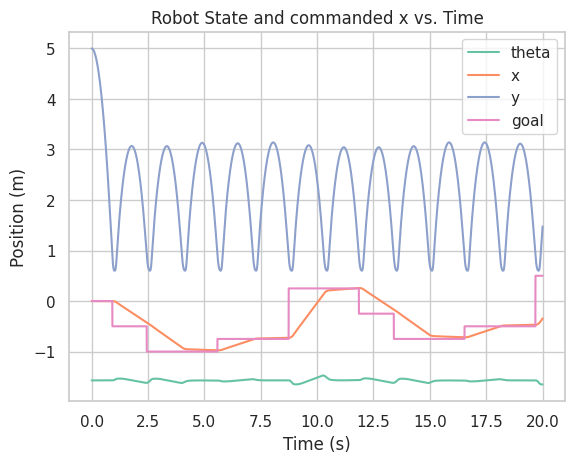

In [14]:
sns.set_theme(style="whitegrid", palette=sns.color_palette("Set2"))

qs_np = np.stack(qs, axis=0)
ts = np.arange(len(qs_np)) * time_step

# Plot the target positions from the hop_lens
bounce_goal = np.zeros_like(ts).squeeze()
bounce_goal[np.array(bounce_idxs, dtype=np.int32)] = bounce_targets
goal = np.cumsum(bounce_goal)


dataframe = pd.DataFrame(
    {
        "t": ts,
        "theta": qs_np[:, 0],
        "x": qs_np[:, 1],
        "y": qs_np[:, 2],
        "goal": goal,
    }
)

sns.lineplot(dataframe, x="t", y="theta", label="theta")
sns.lineplot(dataframe, x="t", y="x", label="x")
sns.lineplot(dataframe, x="t", y="y", label="y")
sns.lineplot(dataframe, x="t", y="goal", label="goal")

plt.title("Robot State and commanded x vs. Time")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")

In [15]:
mean_air_time = np.mean(np.diff(np.array(bounce_idxs) * time_step))
print(f"Mean air time: {mean_air_time}\nTarget air time: {1.5}")

Mean air time: 1.56375
Target air time: 1.5


In [16]:
fps = 60
n_frames = int(end_t * fps)
stride = int(len(qs) / n_frames)

list(range(100))[::stride]
1 / fps

anim = animate_robot(qs[::stride], 1000 / fps)
plt.close()
HTML(anim.to_html5_video())

# Test different commanded air times

In [17]:
init_q = np.array([-np.pi / 2, 0, 5.0, 0])
init_qd = np.array([0.0, 0, 0, 0])

air_times = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
air_times_achieved = []
air_times_commanded = []

for air_time in air_times:
    qs = [init_q]
    qds = [init_qd]

    end_t = 20.0
    time_step = 0.005
    optim_dt = 0.025
    traj_substep = 10

    steps = int(end_t / time_step)

    stance_height = 1.0

    debounce_counter = 0
    debounce_thold = 5
    bounce_counter = 0
    standing = False
    bounce_idxs = []
    bounce_targets = []

    hop_lens = [0.0]

    for i in range(steps):
        # print(i)
        hop_len = hop_lens[bounce_counter % len(hop_lens)]
        ref_traj, stance = make_single_hop_reference_trajectory(
            qs[-1],
            qds[-1],
            hop_len,
            air_time,
            params,
            contact_height=stance_height,
            bottom_height=0.6,
            dt=optim_dt / traj_substep,
        )

        # Define PD control
        axis_pos = np.array([qs[-1][0], qs[-1][3]])
        axis_vel = np.array([qds[-1][0], qds[-1][3]])
        axis_target = np.array([ref_traj[0, 0], 0.0])
        axis_perr = axis_target - axis_pos
        axis_verr = np.array([ref_traj[0][3], 0.0]) - axis_vel
        axis_verr = axis_verr

        dp = np.array([5.0, 5.0])
        dd = np.array([1.0, 1.0])
        u = dp * axis_perr + dd * axis_verr

        if stance[0]:
            ref_traj = ref_traj[::traj_substep]
            stance = stance[::traj_substep]
            soln = optimize_traj(
                qs[-1],
                qds[-1],
                ref_traj,
                stance,
                params,
                dt=optim_dt,
            )
            soln = np.array(
                soln
            ).squeeze()  # This is the commanded reaction force from the foot.

            foot_jac_t = foot_J_func(qs[-1]).T[[0, 3]]
            u = foot_jac_t @ (-soln[0:2] - np.array([0, g]) * (m_b + m_l))

        M = A_func(qs[-1], qds[-1], params)
        M_inv = np.linalg.inv(M)
        qdd = dynamics(qs[-1], qds[-1], u, params)
        new_qd = qds[-1] + qdd.squeeze() * time_step
        new_q = qs[-1] + new_qd * time_step

        contact_update, hit = contact(new_q, new_qd, params)
        if hit:
            if not standing:
                debounce_counter += 1
            else:
                debounce_counter = 0
            if debounce_counter >= debounce_thold:
                standing = True
                debounce_counter = 0

                bounce_counter += 1
                print(f"Bounce: {bounce_counter}")
                bounce_idxs.append(i)
                bounce_targets.append(hop_lens[bounce_counter % len(hop_lens)])

            new_qd += contact_update.squeeze()
            new_q = qs[-1] + new_qd * time_step
        else:
            if standing:
                debounce_counter += 1
            else:
                debounce_counter = 0
            if debounce_counter >= debounce_thold:
                standing = False
                debounce_counter = 0

        qds.append(new_qd)
        qs.append(new_q)

    air_times_just_achieved = np.diff(np.array(bounce_idxs) * time_step)

    air_times_commanded.append(np.ones_like(air_times_just_achieved) * air_time)
    air_times_achieved.append(np.diff(np.array(bounce_idxs) * time_step))

Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 12
Bounce: 13
Bounce: 14
Bounce: 15
Bounce: 16
Bounce: 17
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 12
Bounce: 13
Bounce: 14
Bounce: 15
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 12
Bounce: 13
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 10
Bounce: 11
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 9
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 8
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 7
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5
Bounce: 6
Bounce: 1
Bounce: 2
Bounce: 3
Bounce: 4
Bounce: 5


Text(0, 0.5, 'Achieved air time')

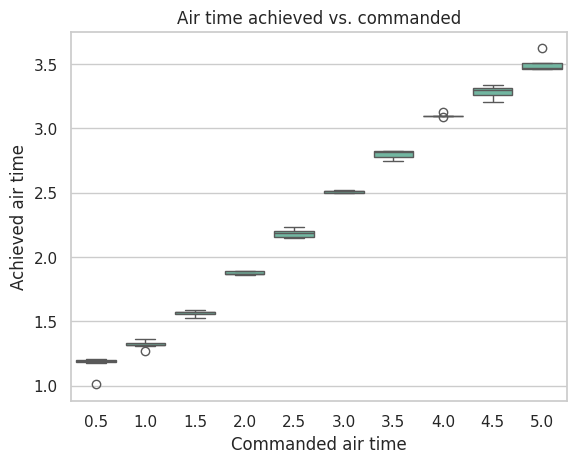

In [18]:
dataframe = pd.DataFrame(
    {
        "commanded": np.concatenate(air_times_commanded),
        "achieved": np.concatenate(air_times_achieved),
    }
)

sns.boxplot(dataframe, x="commanded", y="achieved")

plt.title("Air time achieved vs. commanded")
plt.xlabel("Commanded air time")
plt.ylabel("Achieved air time")

# [Link](https://youtube.com/shorts/OfxgZYVft2U) to youtube video of the simulation
https://youtube.com/shorts/OfxgZYVft2U